In [1]:
import sys
sys.path.append("../utils/")
from runner import Runner
from filter_variants import FilterVariants

In [2]:
import pandas as pd
from datetime import datetime
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.visualization.petri_net import visualizer as pn_visualizer

In [3]:
exp_name = "Matrix-Chain"
script_path = "../Matrix-Chain-4/variants-linnea/generate-variants-linnea.py"
args = ["10","110","120","130","500"]
runner = Runner("Matrix-Chain", script_path , args)

ret = runner.generate_run_experiments(bRun=True, bGenerate=True)
case_table,_,event_table = runner.get_all_tables(meta=False)

New solution:.............2.71e+06
No further generation steps possible.
----------------------------------
Number of nodes:                 8
Solution nodes:                  1
Data:                     1.38e+05
Best solution:            2.71e+06
Intensity:                    19.7
Number of algorithms:            6
Generated Variants.
Running Experiments
Experiments completed


In [4]:
filter_variants = FilterVariants(case_table,event_table)

In [5]:
competing_ct, competing_et = filter_variants.filter_best_flops_duration()

In [6]:
competing_ct

,case:concept:name,case:timestamp:start,case:timestamp:end,case:duration,case:flops,case:num_kernels,case:rel-flops,case:rel-duration
3,algorithm0,1.655370e+09,1.655370e+09,0.000465,2710000.0,3,0.0,0.000006
2,algorithm4,1.655370e+09,1.655370e+09,0.000459,29100000.0,3,26390000.0,0.000000


In [7]:
competing_et

,case:concept:name,concept:name,concept:flops,concept:operation,concept:kernel,timestamp:start,timestamp:end
6,algorithm4,gemm_1.56e+07,15600000.0,tmp3 = (C D),"gemm!('N', 'N', 1.0, ml2, ml3, 0.0, ml4)",1.655370e+09,1.655370e+09
7,algorithm4,gemm_2.64e+05,264000.0,tmp1 = (A B),"gemm!('N', 'N', 1.0, ml0, ml1, 0.0, ml5)",1.655370e+09,1.655370e+09
8,algorithm4,gemm_1.32e+07,13200000.0,tmp6 = (tmp1 tmp3),"gemm!('N', 'N', 1.0, ml5, ml4, 0.0, ml6)",1.655370e+09,1.655370e+09
9,algorithm0,gemm_3.12e+05,312000.0,tmp2 = (B C),"gemm!('N', 'N', 1.0, ml1, ml2, 0.0, ml4)",1.655370e+09,1.655370e+09
10,algorithm0,gemm_1.3e+06,1300000.0,tmp5 = (tmp2 D),"gemm!('N', 'N', 1.0, ml4, ml3, 0.0, ml5)",1.655370e+09,1.655370e+09
11,algorithm0,gemm_1.1e+06,1100000.0,tmp6 = (A tmp5),"gemm!('N', 'N', 1.0, ml0, ml5, 0.0, ml6)",1.655370e+09,1.655370e+09


In [8]:
def convert_timestamp_todtime(timestamp):
    return datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S.%f')

def convert_timestamp_format(df):
    df['timestamp:start'] = df['timestamp:start'].apply(convert_timestamp_todtime)
    df['timestamp:end'] = df['timestamp:end'].apply(convert_timestamp_todtime)
    df = dataframe_utils.convert_timestamp_columns_in_df(df)

In [15]:
class DiscoverPN:
    """Creates an xes eventlog from the dataframes: case_table and event table
    The eventlog is used to discover process models"""
    
    def __init__(self, event_table, case_table=None):
        """INPUT: dataframes: case_table and event_table
            Upon initialization, the case and event tables are merged
            and converted to an xes event log format. The dataframes are not stored. 
        """
        log = event_table.copy()
        convert_timestamp_format(log)       
        log = log.sort_values('timestamp:start')
        if case_table:
            log = log.merge(case_table, on='case:concept:name')
        
        self.event_log = log_converter.apply(log)
        log = None
        
    def inductive_miner(self, activity='concept:name',filtered_log=None):
        """apply inductive mining on the filtered log.
        if no filtered_log is passed, self.event_log is used.
        
        Input (optional): event log
        Output: petrinet, initial marking, final marking"""
    
        log = self.event_log
        if filtered_log:
            log = filtered_log
        parameters = {
            inductive_miner.Variants.IM_CLEAN.value.Parameters.ACTIVITY_KEY: activity
        }
        return inductive_miner.apply(log,parameters=parameters)
    
    def visualize_pn(self,net,im,fm):
        """visualize petrinet
        Input: net, inital and final marking
        Returns nothing."""
        gviz = pn_visualizer.apply(net, im, fm)
        pn_visualizer.view(gviz)
        

In [16]:
pn = DiscoverPN(competing_et)
#pn = DiscoverPN(competing_et, competing_ct)

In [17]:
pn.event_log

[{'attributes': {'concept:name': 'algorithm4'}, 'events': [{'concept:name': 'gemm_1.56e+07', 'concept:flops': 15600000.0, 'concept:operation': 'tmp3 = (C D)', 'concept:kernel': "gemm!('N', 'N', 1.0, ml2, ml3, 0.0, ml4)", 'timestamp:start': Timestamp('2022-06-16 10:53:01.873055+0000', tz='UTC'), 'timestamp:end': Timestamp('2022-06-16 10:53:01.873293+0000', tz='UTC')}, '..', {'concept:name': 'gemm_1.32e+07', 'concept:flops': 13200000.0, 'concept:operation': 'tmp6 = (tmp1 tmp3)', 'concept:kernel': "gemm!('N', 'N', 1.0, ml5, ml4, 0.0, ml6)", 'timestamp:start': Timestamp('2022-06-16 10:53:01.873308+0000', tz='UTC'), 'timestamp:end': Timestamp('2022-06-16 10:53:01.873514+0000', tz='UTC')}]}, '....', {'attributes': {'concept:name': 'algorithm0'}, 'events': [{'concept:name': 'gemm_3.12e+05', 'concept:flops': 312000.0, 'concept:operation': 'tmp2 = (B C)', 'concept:kernel': "gemm!('N', 'N', 1.0, ml1, ml2, 0.0, ml4)", 'timestamp:start': Timestamp('2022-06-16 10:53:01.873570+0000', tz='UTC'), 'tim

In [18]:
for trace in pn.event_log:
    print(trace.attributes)

{'concept:name': 'algorithm4'}
{'concept:name': 'algorithm0'}


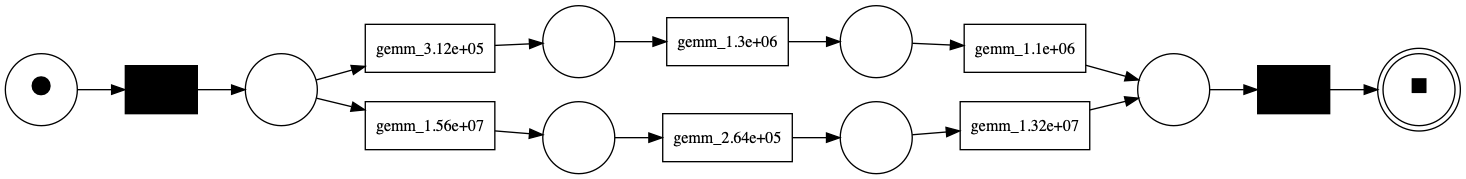

In [21]:
#net, im, fm = pn.inductive_miner(activity='concept:operation')
net, im, fm = pn.inductive_miner()
pn.visualize_pn(net, im, fm)

In [14]:
inductive_miner.Variants.IM_CLEAN.value.Parameters.ACTIVITY_KEY 

<Parameters.ACTIVITY_KEY: 'pm4py:param:activity_key'>